## The aim of this lab is to build a system for sentiment analysis on a dataset of tweets.

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

The data consist on passenger's reviews of U.S. airlines: https://www.kaggle.com/crowdflower/twitter-airline-sentiment 

In [3]:
data = pd.read_csv('2020.deeplearning/local/data/Tweets.csv')
# Keeping only the neccessary columns
data = data[['text','airline_sentiment']]

In [4]:
data

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


In [6]:
import re
#Remove neutral class
data = data[data.airline_sentiment != "neutral"]

#text normalization
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x:re.sub('@[^\s]+','',x)))#remove the name of the airline
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
print(np.sum(data['airline_sentiment'].values == 'positive'))
print(np.sum(data['airline_sentiment'].values == 'negative'))

2363
9178


In [7]:
data

,text,airline_sentiment
1,plus youve added commercials to the experienc...,positive
3,its really aggressive to blast obnoxious ente...,negative
4,and its a really big bad thing about it,negative
5,seriously would pay 30 a flight for seats tha...,negative
6,yes nearly every time i fly vx this ear worm ...,positive
...,...,...
14633,my flight was cancelled flightled leaving tom...,negative
14634,right on cue with the delays,negative
14635,thank you we got on a different flight to chi...,positive
14636,leaving over 20 minutes late flight no warnin...,negative


In [8]:
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

In [9]:
data

,text,airline_sentiment
1,plus youve added commercials to the experienc...,positive
3,its really aggressive to blast obnoxious ente...,negative
4,and its a really big bad thing about it,negative
5,seriously would pay 30 a flight for seats tha...,negative
6,yes nearly every time i fly vx this ear worm ...,positive
...,...,...
14633,my flight was cancelled flightled leaving tom...,negative
14634,right on cue with the delays,negative
14635,thank you we got on a different flight to chi...,positive
14636,leaving over 20 minutes late flight no warnin...,negative


In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/julian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/julian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Removing Stop Words
from nltk.corpus import stopwords
all_sentences = data['text'].values
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
stop_words = stopwords.words('english')
stop_words.append('')

for i in range(len(all_words)):  
    all_words[i] = [w for w in all_words[i] if w not in stop_words]

## Exercise 1

all_words is a list with all the tweets that are going to be used to train the model. Tokenize the tweets using a dictionary of 2000 words. Once the sentences are tokenized, take into account that the length of every tweet is different so before they can be passed to the training step, the tweets must be **padded** in order to provide them with equal length.

Review the padding function in the preprocessing module of keras and apply it to the tokenized sequences. 

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_fatures = 2001
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(all_words)

In [13]:
X = tokenizer.texts_to_sequences(all_words)

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
NewX = pad_sequences(sequences=X, padding="post", value=0)

In [15]:
NewX.shape

(11541, 21)

## Exercise 2

The previous step add 0's to some tweets in order to provide them with the same length. Now it is necessary to define a model that be able to discard those 0's. Review the masking layer and masking option of the embedding layer of keras. 

Define a LSTM architecture to classify the tweets as "negative" or "positive". Use the Embedding layer and its masking option to discard the 0's added during padding step. Evaluate the performance of the model for embed_dim = [32,64,128] and a LSTM layer with cells = [32,64,128]. Use 20% of the data for testing purposes and 10 epochs for training. 

In [14]:
from sklearn.preprocessing import LabelEncoder
y = data['airline_sentiment'].values
Encoder = LabelEncoder()
Encoder.fit(np.unique(y))
Y = Encoder.transform(y)

In [15]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Input, Conv1D, Flatten, Dropout, GlobalMaxPooling1D
from tensorflow.keras import optimizers

In [16]:
def Model_Sentimen(Embeb,cells):
    model = Sequential([
        Embedding(input_dim=max_fatures, output_dim=Embeb, mask_zero=True),
        LSTM(cells,activation='relu'),
        Dense(10,activation='relu'),
        Dropout(0.3),
        Dense(1,activation='sigmoid')
    ])
    return model

In [17]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(NewX, Y, test_size=0.2, random_state=2018)

In [18]:
from sklearn.metrics import recall_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

In [19]:
def especi_score(y_te,y_pred):
    Ns = np.sum(y_te == 0)
    return np.sum(y_te[y_te == 0] == y_pred[y_te == 0])/Ns

In [20]:
#weights = compute_class_weight('balanced', np.unique(y_tr), y_tr)
#weights = weights[::-1]
sensitivity = np.zeros((3,3))
especificity = np.zeros((3,3))
accuracy = np.zeros((3,3))
for i, embed_dim in enumerate([32,64,128]):
    for j,cells in enumerate([32,64,128]):
        model = Model_Sentimen(embed_dim,cells)
        #opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
        model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
        y_pred = np.round(model.predict(X_te))
        sensitivity[i,j] = recall_score(y_te,y_pred)
        accuracy[i,j] = accuracy_score(y_te,y_pred)
        especificity[i,j] = especi_score(y_te,y_pred.flatten())        

Train on 8308 samples, validate on 924 samples
Epoch 1/10
8308/8308 [==============================] - 2s 290us/sample - loss: 0.4047 - accuracy: 0.8315 - val_loss: 0.2892 - val_accuracy: 0.9080
Epoch 2/10
8308/8308 [==============================] - 2s 181us/sample - loss: 0.2064 - accuracy: 0.9253 - val_loss: 0.3267 - val_accuracy: 0.9058
Epoch 3/10
8308/8308 [==============================] - 1s 178us/sample - loss: 0.1544 - accuracy: 0.9405 - val_loss: 0.3455 - val_accuracy: 0.9015
Epoch 4/10
8308/8308 [==============================] - 1s 179us/sample - loss: 0.1294 - accuracy: 0.9498 - val_loss: 0.4853 - val_accuracy: 0.9026
Epoch 5/10
8308/8308 [==============================] - 2s 183us/sample - loss: 0.1093 - accuracy: 0.9573 - val_loss: 0.5668 - val_accuracy: 0.9037
Epoch 6/10
8308/8308 [==============================] - 2s 181us/sample - loss: 0.0925 - accuracy: 0.9652 - val_loss: 0.4965 - val_accuracy: 0.9026
Epoch 7/10
8308/8308 [==============================] - 1s 180us/

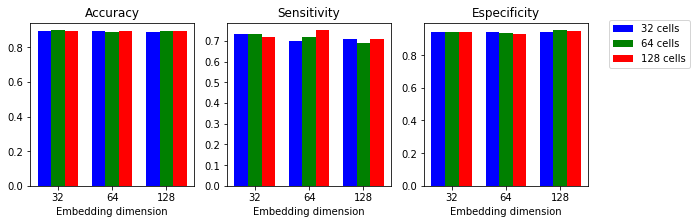

Best accuracy= 0.8973581637072325


In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
X = np.arange(3)
ax1.bar(X + 0.00, accuracy[0,:], color = 'b', width = 0.25)
ax1.bar(X + 0.25, accuracy[1,:], color = 'g', width = 0.25)
ax1.bar(X + 0.50, accuracy[2,:], color = 'r', width = 0.25)
ax1.set_xticks([0.25, 1.25, 2.25])
ax1.set_xticklabels(['32','64', '128'])
ax1.set_title('Accuracy')
ax1.set_xlabel('Embedding dimension')
ax2.bar(X + 0.00, sensitivity[0,:], color = 'b', width = 0.25)
ax2.bar(X + 0.25, sensitivity[1,:], color = 'g', width = 0.25)
ax2.bar(X + 0.50, sensitivity[2,:], color = 'r', width = 0.25)
ax2.set_xticks([0.25, 1.25, 2.25])
ax2.set_xticklabels(['32','64', '128'])
ax2.set_title('Sensitivity')
ax2.set_xlabel('Embedding dimension')
ax3.bar(X + 0.00, especificity[0,:], color = 'b', width = 0.25)
ax3.bar(X + 0.25, especificity[1,:], color = 'g', width = 0.25)
ax3.bar(X + 0.50, especificity[2,:], color = 'r', width = 0.25)
ax3.set_xticks([0.25, 1.25, 2.25])
ax3.set_xticklabels(['32','64', '128'])
ax3.set_title('Especificity')
ax3.set_xlabel('Embedding dimension')
ax3.legend(labels=['32 cells','64 cells','128 cells'],bbox_to_anchor=(1.1, 1.05))
plt.show()
print('Best accuracy= {}'.format(np.max(accuracy)))

## Exercise 3

Train a CBOW model with the dataset using and Embedding dimension of [32,64,128]. Create a new network and transfer the pretrained weights to the Embedding layer. Use the same architecture than before (except for the Embedding layer). Compare the results.

**Note**: Take care on the tokenization of the words. Keras tokenizer does not assign the zero value to any word because of padding purposes. Make sure that the order of the vectors in the GloVe embedding matrix corresponds with the indexs used to represent the words in the data. 

In [22]:
words = list(tokenizer.word_index)

In [23]:
from gensim.sklearn_api import W2VTransformer

In [24]:
def Model_Sentimen(Embeb,cells,wordsmatrix):
    model = Sequential([
        Embedding(input_dim=max_fatures, output_dim=Embeb, weights = [np.r_[np.zeros((1,Embeb)),wordsmatrix]], trainable = False, mask_zero=True),
        LSTM(cells,activation='relu'),
        Dense(10,activation='relu'),
        Dropout(0.3),
        Dense(1,activation='sigmoid')
    ])
    return model

In [25]:
sensitivity = np.zeros((3,3))
especificity = np.zeros((3,3))
accuracy = np.zeros((3,3))
for i, embed_dim in enumerate([32,64,128]):
    for j,cells in enumerate([32,64,128]):
        #---------------------------------------------------------------------------------
        model_CBOW = W2VTransformer(size=embed_dim, window = 10, max_vocab_size= len(tokenizer.word_index), min_count=0, seed=1, sg = 0, hs=1, iter = 50)
        model_CBOW.fit(all_words)
        wordsmatrix = model_CBOW.transform(words[:2000])
        #-------------------------------------------------------------------------------------
        model = Model_Sentimen(embed_dim,cells,wordsmatrix)
        #opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
        model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
        y_pred = np.round(model.predict(X_te))
        sensitivity[i,j] = recall_score(y_te,y_pred)
        accuracy[i,j] = accuracy_score(y_te,y_pred)
        especificity[i,j] = especi_score(y_te,y_pred.flatten())     

Train on 8308 samples, validate on 924 samples
Epoch 1/10
8308/8308 [==============================] - 2s 287us/sample - loss: 0.4109 - accuracy: 0.8303 - val_loss: 0.3080 - val_accuracy: 0.8777
Epoch 2/10
8308/8308 [==============================] - 1s 166us/sample - loss: 0.2982 - accuracy: 0.8914 - val_loss: 0.3073 - val_accuracy: 0.8766
Epoch 3/10
8308/8308 [==============================] - 1s 166us/sample - loss: 0.2652 - accuracy: 0.8997 - val_loss: 0.2912 - val_accuracy: 0.8820
Epoch 4/10
8308/8308 [==============================] - 1s 166us/sample - loss: 0.2475 - accuracy: 0.9096 - val_loss: 0.2983 - val_accuracy: 0.8810
Epoch 5/10
8308/8308 [==============================] - 1s 166us/sample - loss: 0.2355 - accuracy: 0.9108 - val_loss: 0.2859 - val_accuracy: 0.8853
Epoch 6/10
8308/8308 [==============================] - 1s 166us/sample - loss: 0.2168 - accuracy: 0.9160 - val_loss: 0.2953 - val_accuracy: 0.8810
Epoch 7/10
8308/8308 [==============================] - 1s 166us/

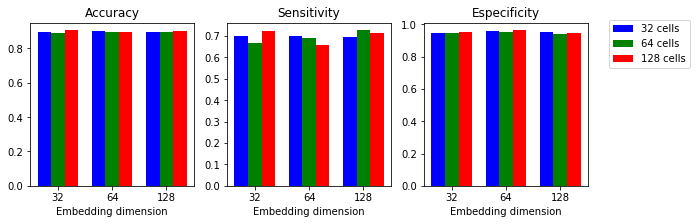

Best accuracy= 0.9034213945430922


In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
X = np.arange(3)
ax1.bar(X + 0.00, accuracy[0,:], color = 'b', width = 0.25)
ax1.bar(X + 0.25, accuracy[1,:], color = 'g', width = 0.25)
ax1.bar(X + 0.50, accuracy[2,:], color = 'r', width = 0.25)
ax1.set_xticks([0.25, 1.25, 2.25])
ax1.set_xticklabels(['32','64', '128'])
ax1.set_title('Accuracy')
ax1.set_xlabel('Embedding dimension')
ax2.bar(X + 0.00, sensitivity[0,:], color = 'b', width = 0.25)
ax2.bar(X + 0.25, sensitivity[1,:], color = 'g', width = 0.25)
ax2.bar(X + 0.50, sensitivity[2,:], color = 'r', width = 0.25)
ax2.set_xticks([0.25, 1.25, 2.25])
ax2.set_xticklabels(['32','64', '128'])
ax2.set_title('Sensitivity')
ax2.set_xlabel('Embedding dimension')
ax3.bar(X + 0.00, especificity[0,:], color = 'b', width = 0.25)
ax3.bar(X + 0.25, especificity[1,:], color = 'g', width = 0.25)
ax3.bar(X + 0.50, especificity[2,:], color = 'r', width = 0.25)
ax3.set_xticks([0.25, 1.25, 2.25])
ax3.set_xticklabels(['32','64', '128'])
ax3.set_title('Especificity')
ax3.set_xlabel('Embedding dimension')
ax3.legend(labels=['32 cells','64 cells','128 cells'],bbox_to_anchor=(1.1, 1.05))
plt.show()
print('Best accuracy= {}'.format(np.max(accuracy)))

#### Prueba entrenando GloVe

In [46]:
all_sentences2 = []
for i in range(len(all_words)):
    temp = all_words[i]
    sen = ''
    for j in range(len(temp)):
        sen = sen + ' ' +temp[j]
    all_sentences2.append(sen)
        

In [48]:
import logging
from local.lib.glove import evaluate
from local.lib.glove import glove

glove.logger.setLevel(logging.ERROR)

vocab = glove.build_vocab(all_sentences2)    
#Coocurrence matrix
cooccur = glove.build_cooccur(vocab, all_sentences2, window_size=10)
id2word = evaluate.make_id2word(vocab)

In [56]:
sensitivity = np.zeros((3,3))
especificity = np.zeros((3,3))
accuracy = np.zeros((3,3))
for i, embed_dim in enumerate([32,64,128]):
    for j,cells in enumerate([32,64,128]):
        #---------------------------------------------------------------------------------
        W = glove.train_glove(vocab, cooccur, vector_size=embed_dim, iterations=15)
        # Merge and normalize word vectors
        W = evaluate.merge_main_context(W)
        indice = np.zeros(2000, dtype=int)
        for k in range(2000):
            indice[k] = vocab.get(words[k])[0]
        wordsmatrix = W[indice,:]
        #-------------------------------------------------------------------------------------
        model = Model_Sentimen(embed_dim,cells,wordsmatrix)
        opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
        model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
        y_pred = np.round(model.predict(X_te))
        sensitivity[i,j] = recall_score(y_te,y_pred)
        accuracy[i,j] = accuracy_score(y_te,y_pred)
        especificity[i,j] = especi_score(y_te,y_pred.flatten())     

Train on 7724 samples, validate on 859 samples
Epoch 1/30
7724/7724 [==============================] - 3s 404us/sample - loss: 0.5264 - accuracy: 0.7916 - val_loss: 0.4953 - val_accuracy: 0.7905
Epoch 2/30
7724/7724 [==============================] - 1s 176us/sample - loss: 0.4920 - accuracy: 0.7938 - val_loss: 0.4924 - val_accuracy: 0.7963
Epoch 3/30
7724/7724 [==============================] - 1s 174us/sample - loss: 0.4805 - accuracy: 0.7947 - val_loss: 0.4847 - val_accuracy: 0.7835
Epoch 4/30
7724/7724 [==============================] - 1s 172us/sample - loss: 0.4734 - accuracy: 0.7956 - val_loss: 0.4971 - val_accuracy: 0.7905
Epoch 5/30
7724/7724 [==============================] - 1s 174us/sample - loss: 0.4683 - accuracy: 0.7958 - val_loss: 0.4684 - val_accuracy: 0.7963
Epoch 6/30
7724/7724 [==============================] - 1s 173us/sample - loss: 0.4588 - accuracy: 0.7982 - val_loss: 0.4619 - val_accuracy: 0.8079
Epoch 7/30
7724/7724 [==============================] - 1s 173us/

7724/7724 [==============================] - 1s 168us/sample - loss: 0.4005 - accuracy: 0.8246 - val_loss: 0.4417 - val_accuracy: 0.8149
Epoch 20/30
7724/7724 [==============================] - 1s 168us/sample - loss: 0.3979 - accuracy: 0.8272 - val_loss: 0.4470 - val_accuracy: 0.8207
Epoch 21/30
7724/7724 [==============================] - 1s 168us/sample - loss: 0.3952 - accuracy: 0.8291 - val_loss: 0.4390 - val_accuracy: 0.8265
Epoch 22/30
7724/7724 [==============================] - 1s 168us/sample - loss: 0.3922 - accuracy: 0.8285 - val_loss: 0.4421 - val_accuracy: 0.8056
Epoch 23/30
7724/7724 [==============================] - 1s 168us/sample - loss: 0.3906 - accuracy: 0.8314 - val_loss: 0.4376 - val_accuracy: 0.8184
Epoch 24/30
7724/7724 [==============================] - 1s 168us/sample - loss: 0.3859 - accuracy: 0.8334 - val_loss: 0.4635 - val_accuracy: 0.8102
Epoch 25/30
7724/7724 [==============================] - 1s 168us/sample - loss: 0.3851 - accuracy: 0.8336 - val_loss:

7724/7724 [==============================] - 2s 207us/sample - loss: 0.4421 - accuracy: 0.8107 - val_loss: 0.4609 - val_accuracy: 0.8056
Epoch 8/30
7724/7724 [==============================] - 2s 206us/sample - loss: 0.4308 - accuracy: 0.8128 - val_loss: 0.4363 - val_accuracy: 0.8254
Epoch 9/30
7724/7724 [==============================] - 2s 207us/sample - loss: 0.4241 - accuracy: 0.8140 - val_loss: 0.4334 - val_accuracy: 0.8231
Epoch 10/30
7724/7724 [==============================] - 2s 206us/sample - loss: 0.4194 - accuracy: 0.8185 - val_loss: 0.4230 - val_accuracy: 0.8312
Epoch 11/30
7724/7724 [==============================] - 2s 207us/sample - loss: 0.4139 - accuracy: 0.8228 - val_loss: 0.4313 - val_accuracy: 0.8254
Epoch 12/30
7724/7724 [==============================] - 2s 206us/sample - loss: 0.4111 - accuracy: 0.8226 - val_loss: 0.4256 - val_accuracy: 0.8254
Epoch 13/30
7724/7724 [==============================] - 2s 207us/sample - loss: 0.4078 - accuracy: 0.8202 - val_loss: 0

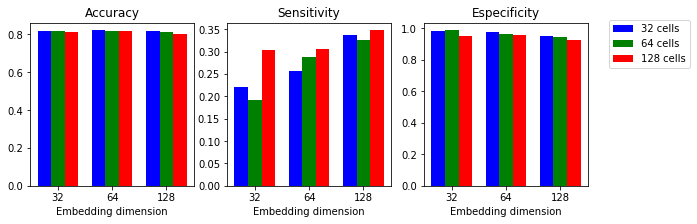

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
X = np.arange(3)
ax1.bar(X + 0.00, accuracy[0,:], color = 'b', width = 0.25)
ax1.bar(X + 0.25, accuracy[1,:], color = 'g', width = 0.25)
ax1.bar(X + 0.50, accuracy[2,:], color = 'r', width = 0.25)
ax1.set_xticks([0.25, 1.25, 2.25])
ax1.set_xticklabels(['32','64', '128'])
ax1.set_title('Accuracy')
ax1.set_xlabel('Embedding dimension')
ax2.bar(X + 0.00, sensitivity[0,:], color = 'b', width = 0.25)
ax2.bar(X + 0.25, sensitivity[1,:], color = 'g', width = 0.25)
ax2.bar(X + 0.50, sensitivity[2,:], color = 'r', width = 0.25)
ax2.set_xticks([0.25, 1.25, 2.25])
ax2.set_xticklabels(['32','64', '128'])
ax2.set_title('Sensitivity')
ax2.set_xlabel('Embedding dimension')
ax3.bar(X + 0.00, especificity[0,:], color = 'b', width = 0.25)
ax3.bar(X + 0.25, especificity[1,:], color = 'g', width = 0.25)
ax3.bar(X + 0.50, especificity[2,:], color = 'r', width = 0.25)
ax3.set_xticks([0.25, 1.25, 2.25])
ax3.set_xticklabels(['32','64', '128'])
ax3.set_title('Especificity')
ax3.set_xlabel('Embedding dimension')
ax3.legend(labels=['32 cells','64 cells','128 cells'],bbox_to_anchor=(1.1, 1.05))
plt.show()

### Cargando GloVe pre-entrenados

In [27]:
word_index = tokenizer.word_index

In [28]:
def Model_Sentimen(Embeb,cells,wordsmatrix):
    model = Sequential([
        Embedding(input_dim=max_fatures, output_dim=Embeb, weights = [wordsmatrix], trainable = False, mask_zero=True),
        LSTM(cells,activation='relu'),
        Dense(10,activation='relu'),
        Dropout(0.3),
        Dense(1,activation='sigmoid')
    ])
    return model

In [29]:
import os
GLOVE_DIR = '/home/julian/Documents/Datasets/glove.twitter.27B/'
def load_embeddings(dim):
    embeddings_index = {}
    f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.'+ str(dim)+'d.txt'))
    for line in f:
        values = line.split()
        word_g = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word_g] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [30]:
def load_embedding_matrix(embeddings_index,EMBEDDING_DIM):
    #EMBEDDING_DIM = 25
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [31]:
sensitivity = np.zeros((3,3))
especificity = np.zeros((3,3))
accuracy = np.zeros((3,3))
for i, embed_dim in enumerate([25,50,100]):
    for j,cells in enumerate([32,64,128]):
        #---------------------------------------------------------------------------------
        embeddings_index = load_embeddings(embed_dim)
        embedding_matrix = load_embedding_matrix(embeddings_index,embed_dim)
        wordsmatrix = embedding_matrix[:2001,:]
        #-------------------------------------------------------------------------------------
        model = Model_Sentimen(embed_dim,cells,wordsmatrix)
        opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
        model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
        y_pred = np.round(model.predict(X_te))
        sensitivity[i,j] = recall_score(y_te,y_pred)
        accuracy[i,j] = accuracy_score(y_te,y_pred)
        especificity[i,j] = especi_score(y_te,y_pred.flatten())

Found 1193514 word vectors.
Train on 8308 samples, validate on 924 samples
Epoch 1/10
8308/8308 [==============================] - 2s 299us/sample - loss: 0.3930 - accuracy: 0.8316 - val_loss: 0.3240 - val_accuracy: 0.8788
Epoch 2/10
8308/8308 [==============================] - 1s 172us/sample - loss: 0.2992 - accuracy: 0.8823 - val_loss: 0.2969 - val_accuracy: 0.8842
Epoch 3/10
8308/8308 [==============================] - 1s 172us/sample - loss: 0.2787 - accuracy: 0.8871 - val_loss: 0.2871 - val_accuracy: 0.8842
Epoch 4/10
8308/8308 [==============================] - 1s 170us/sample - loss: 0.2681 - accuracy: 0.8917 - val_loss: 0.2838 - val_accuracy: 0.8842
Epoch 5/10
8308/8308 [==============================] - 1s 172us/sample - loss: 0.2550 - accuracy: 0.8965 - val_loss: 0.2867 - val_accuracy: 0.8929
Epoch 6/10
8308/8308 [==============================] - 1s 170us/sample - loss: 0.2527 - accuracy: 0.8988 - val_loss: 0.2809 - val_accuracy: 0.8896
Epoch 7/10
8308/8308 [===============

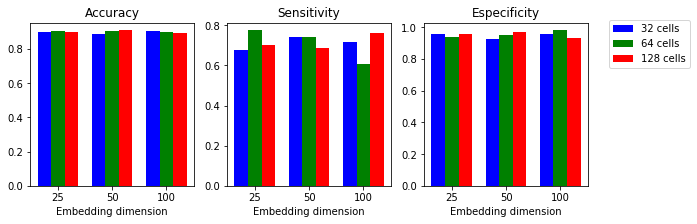

Best accuracy= 0.9081853616284106


In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
X = np.arange(3)
ax1.bar(X + 0.00, accuracy[0,:], color = 'b', width = 0.25)
ax1.bar(X + 0.25, accuracy[1,:], color = 'g', width = 0.25)
ax1.bar(X + 0.50, accuracy[2,:], color = 'r', width = 0.25)
ax1.set_xticks([0.25, 1.25, 2.25])
ax1.set_xticklabels(['25','50', '100'])
ax1.set_title('Accuracy')
ax1.set_xlabel('Embedding dimension')
ax2.bar(X + 0.00, sensitivity[0,:], color = 'b', width = 0.25)
ax2.bar(X + 0.25, sensitivity[1,:], color = 'g', width = 0.25)
ax2.bar(X + 0.50, sensitivity[2,:], color = 'r', width = 0.25)
ax2.set_xticks([0.25, 1.25, 2.25])
ax2.set_xticklabels(['25','50', '100'])
ax2.set_title('Sensitivity')
ax2.set_xlabel('Embedding dimension')
ax3.bar(X + 0.00, especificity[0,:], color = 'b', width = 0.25)
ax3.bar(X + 0.25, especificity[1,:], color = 'g', width = 0.25)
ax3.bar(X + 0.50, especificity[2,:], color = 'r', width = 0.25)
ax3.set_xticks([0.25, 1.25, 2.25])
ax3.set_xticklabels(['25','50', '100'])
ax3.set_title('Especificity')
ax3.set_xlabel('Embedding dimension')
ax3.legend(labels=['32 cells','64 cells','128 cells'],bbox_to_anchor=(1.1, 1.05))
plt.show()
print('Best accuracy= {}'.format(np.max(accuracy)))

In [33]:
GLOVE_DIR = '/home/julian/Documents/Datasets/glove.6B/'
def load_embeddings(dim):
    embeddings_index = {}
    f = open(os.path.join(GLOVE_DIR, 'glove.6B.'+ str(dim)+'d.txt'))
    for line in f:
        values = line.split()
        word_g = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word_g] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [34]:
sensitivity = np.zeros((3,3))
especificity = np.zeros((3,3))
accuracy = np.zeros((3,3))
for i, embed_dim in enumerate([50,100,200]):
    for j,cells in enumerate([32,64,128]):
        #---------------------------------------------------------------------------------
        embeddings_index = load_embeddings(embed_dim)
        embedding_matrix = load_embedding_matrix(embeddings_index,embed_dim)
        wordsmatrix = embedding_matrix[:2001,:]
        #-------------------------------------------------------------------------------------
        model = Model_Sentimen(embed_dim,cells,wordsmatrix)
        opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
        model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
        y_pred = np.round(model.predict(X_te))
        sensitivity[i,j] = recall_score(y_te,y_pred)
        accuracy[i,j] = accuracy_score(y_te,y_pred)
        especificity[i,j] = especi_score(y_te,y_pred.flatten())

Found 400000 word vectors.
Train on 8308 samples, validate on 924 samples
Epoch 1/10
8308/8308 [==============================] - 2s 278us/sample - loss: 0.3986 - accuracy: 0.8346 - val_loss: 0.3231 - val_accuracy: 0.8755
Epoch 2/10
8308/8308 [==============================] - 1s 172us/sample - loss: 0.3000 - accuracy: 0.8805 - val_loss: 0.2968 - val_accuracy: 0.8820
Epoch 3/10
8308/8308 [==============================] - 1s 169us/sample - loss: 0.2786 - accuracy: 0.8852 - val_loss: 0.2877 - val_accuracy: 0.8939
Epoch 4/10
8308/8308 [==============================] - 1s 169us/sample - loss: 0.2606 - accuracy: 0.8942 - val_loss: 0.2873 - val_accuracy: 0.8918
Epoch 5/10
8308/8308 [==============================] - 1s 170us/sample - loss: 0.2489 - accuracy: 0.8987 - val_loss: 0.2820 - val_accuracy: 0.8918
Epoch 6/10
8308/8308 [==============================] - 1s 170us/sample - loss: 0.2351 - accuracy: 0.9018 - val_loss: 0.2891 - val_accuracy: 0.8929
Epoch 7/10
8308/8308 [================

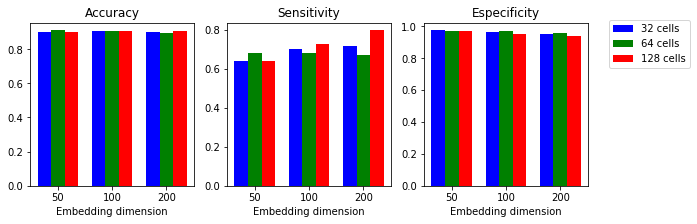

Best accuracy= 0.9086184495452577


In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
X = np.arange(3)
ax1.bar(X + 0.00, accuracy[0,:], color = 'b', width = 0.25)
ax1.bar(X + 0.25, accuracy[1,:], color = 'g', width = 0.25)
ax1.bar(X + 0.50, accuracy[2,:], color = 'r', width = 0.25)
ax1.set_xticks([0.25, 1.25, 2.25])
ax1.set_xticklabels(['50', '100', '200'])
ax1.set_title('Accuracy')
ax1.set_xlabel('Embedding dimension')
ax2.bar(X + 0.00, sensitivity[0,:], color = 'b', width = 0.25)
ax2.bar(X + 0.25, sensitivity[1,:], color = 'g', width = 0.25)
ax2.bar(X + 0.50, sensitivity[2,:], color = 'r', width = 0.25)
ax2.set_xticks([0.25, 1.25, 2.25])
ax2.set_xticklabels(['50', '100', '200'])
ax2.set_title('Sensitivity')
ax2.set_xlabel('Embedding dimension')
ax3.bar(X + 0.00, especificity[0,:], color = 'b', width = 0.25)
ax3.bar(X + 0.25, especificity[1,:], color = 'g', width = 0.25)
ax3.bar(X + 0.50, especificity[2,:], color = 'r', width = 0.25)
ax3.set_xticks([0.25, 1.25, 2.25])
ax3.set_xticklabels(['50', '100', '200'])
ax3.set_title('Especificity')
ax3.set_xlabel('Embedding dimension')
ax3.legend(labels=['32 cells','64 cells','128 cells'],bbox_to_anchor=(1.1, 1.05))
plt.show()
print('Best accuracy= {}'.format(np.max(accuracy)))

## Exercise 4

Use a CNN architeture instead of the LSTM one, combine CNN layers for bigrams and trigrams. You can also use either the keras Embedding Layer or the CBOW embedding matrix. Compare the results.

In [36]:
GLOVE_DIR = '/home/julian/Documents/Datasets/glove.twitter.27B/'
def load_embeddings(dim):
    embeddings_index = {}
    f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.'+ str(dim)+'d.txt'))
    for line in f:
        values = line.split()
        word_g = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word_g] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [37]:
def Model_Sentimen(Embeb,filters):
    model = Sequential([
        #Embedding(input_dim=max_fatures, output_dim=Embeb, weights = [np.r_[np.zeros((1,Embeb)),wordsmatrix]], trainable = False, mask_zero=True),
        Embedding(input_dim=max_fatures, output_dim=Embeb, weights = [wordsmatrix], trainable = False, mask_zero=True),
        Conv1D(filters,kernel_size=3,activation='relu',padding='same'),
        GlobalMaxPooling1D(),
        Flatten(),
        Dense(128,activation='sigmoid'),
        Dropout(0.3),
        Dense(1,activation='sigmoid')
    ])
    return model

In [38]:
sensitivity = np.zeros((3,3))
especificity = np.zeros((3,3))
accuracy = np.zeros((3,3))
for i, embed_dim in enumerate([25,50,100]):
    for j,filters in enumerate([6,12,24]):
        #---------------------------------------------------------------------------------
        embeddings_index = load_embeddings(embed_dim)
        embedding_matrix = load_embedding_matrix(embeddings_index,embed_dim)
        wordsmatrix = embedding_matrix[:2001,:]
        #-------------------------------------------------------------------------------------
        #-------------------------------------------------------------------------------------
        model = Model_Sentimen(embed_dim,filters)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32, epochs=10, verbose=1)
        y_pred = np.round(model.predict(X_te))
        sensitivity[i,j] = recall_score(y_te,y_pred)
        accuracy[i,j] = accuracy_score(y_te,y_pred)
        especificity[i,j] = especi_score(y_te,y_pred.flatten())   

Found 1193514 word vectors.
Train on 8308 samples, validate on 924 samples
Epoch 1/10
8308/8308 [==============================] - 1s 69us/sample - loss: 0.4596 - accuracy: 0.8067 - val_loss: 0.3438 - val_accuracy: 0.8690
Epoch 2/10
8308/8308 [==============================] - 0s 31us/sample - loss: 0.3176 - accuracy: 0.8742 - val_loss: 0.3125 - val_accuracy: 0.8734
Epoch 3/10
8308/8308 [==============================] - 0s 32us/sample - loss: 0.2846 - accuracy: 0.8852 - val_loss: 0.3197 - val_accuracy: 0.8669
Epoch 4/10
8308/8308 [==============================] - 0s 29us/sample - loss: 0.2741 - accuracy: 0.8907 - val_loss: 0.3025 - val_accuracy: 0.8777
Epoch 5/10
8308/8308 [==============================] - 0s 33us/sample - loss: 0.2629 - accuracy: 0.8943 - val_loss: 0.3024 - val_accuracy: 0.8745
Epoch 6/10
8308/8308 [==============================] - 0s 35us/sample - loss: 0.2625 - accuracy: 0.8956 - val_loss: 0.2982 - val_accuracy: 0.8831
Epoch 7/10
8308/8308 [=====================

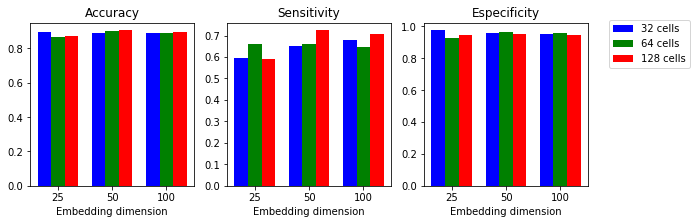

Best accuracy= 0.9047206582936336


In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
X = np.arange(3)
ax1.bar(X + 0.00, accuracy[0,:], color = 'b', width = 0.25)
ax1.bar(X + 0.25, accuracy[1,:], color = 'g', width = 0.25)
ax1.bar(X + 0.50, accuracy[2,:], color = 'r', width = 0.25)
ax1.set_xticks([0.25, 1.25, 2.25])
ax1.set_xticklabels(['25','50', '100'])
ax1.set_title('Accuracy')
ax1.set_xlabel('Embedding dimension')
ax2.bar(X + 0.00, sensitivity[0,:], color = 'b', width = 0.25)
ax2.bar(X + 0.25, sensitivity[1,:], color = 'g', width = 0.25)
ax2.bar(X + 0.50, sensitivity[2,:], color = 'r', width = 0.25)
ax2.set_xticks([0.25, 1.25, 2.25])
ax2.set_xticklabels(['25','50', '100'])
ax2.set_title('Sensitivity')
ax2.set_xlabel('Embedding dimension')
ax3.bar(X + 0.00, especificity[0,:], color = 'b', width = 0.25)
ax3.bar(X + 0.25, especificity[1,:], color = 'g', width = 0.25)
ax3.bar(X + 0.50, especificity[2,:], color = 'r', width = 0.25)
ax3.set_xticks([0.25, 1.25, 2.25])
ax3.set_xticklabels(['25','50', '100'])
ax3.set_title('Especificity')
ax3.set_xlabel('Embedding dimension')
ax3.legend(labels=['32 cells','64 cells','128 cells'],bbox_to_anchor=(1.1, 1.05))
plt.show()
print('Best accuracy= {}'.format(np.max(accuracy)))